In [11]:
'''
This notebook is used to solve the denoising and deconvolution problem, as in the paper.
To get the results of Figure 2, set experiment = "denoising", and set log_SNR .
To get the results of Figure 3, set experiment = "deconvolution", and set log_SNR.
'''
# Core libs
import numpy as np
import time
import os

# Cryo-em libs
from prody import parsePDB

# My libs
from fourier_transform_utils import get_fourier_transform, get_inverse_fourier_transform
from plotting_utils import make_images_for_paper
import generate_synthetic_data as gsd
import priors

np.random.seed(0)

#### Generate molecule.
molecule = "6VXX"
# Choose discretization size
grid_size = 301
save_to_file = False
save_directory =  os.getcwd() + "/results/"  


# Read and center coords
atoms = parsePDB(molecule)
coords = atoms.getCoords()
min_coords = np.min(coords, axis = 0)
max_coords = np.max(coords, axis = 0)
coords = coords - min_coords - (max_coords - min_coords)/2
atoms.setCoords(coords)


# Pad grid for CTF.
grid_physical_size = (np.max(np.abs(coords))+ 1) * 4
voxel_size = grid_physical_size / grid_size 
ft_mol = gsd.generate_volume_from_atoms(atoms, grid_size, voxel_size)
clean_image = np.real(get_inverse_fourier_transform(ft_mol, voxel_size))
image_shape = 3 * [grid_size]


# Get N_atoms and f (atom_shape_fn) from atomic model.
N_atoms = coords.shape[0]
atom_shape_fn = gsd.get_average_atom_shape_fn(atoms)
mask = gsd.mask_from_coordinates(coords, grid_size, voxel_size, atmrad=3, binary_mask=False)
clean_image *= mask


@> PDB file is found in working directory (6vxx.pdb.gz).
@> 23694 atoms and 1 coordinate set(s) were parsed in 0.27s.


kernel radius:  3


diagonal
Time elapsed: 25.234890937805176
wilson
Time elapsed: 366.5978169441223


/Users/marcaurele/research/wilsontest/plotting_utils.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  mrc.set_data(image.astype(np.float32))


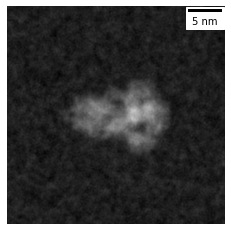

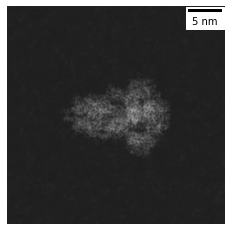

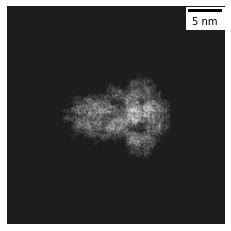

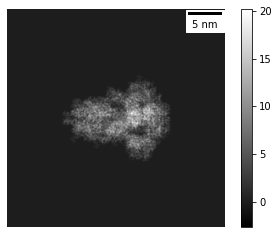

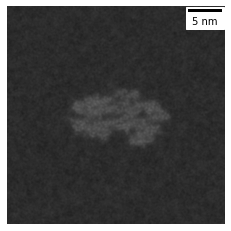

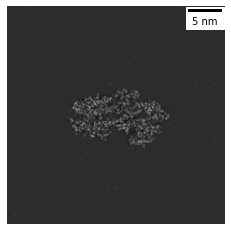

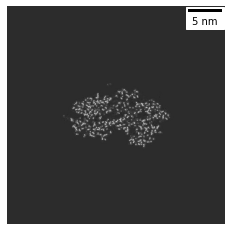

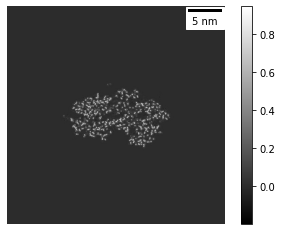

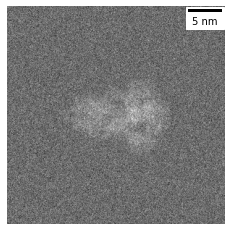

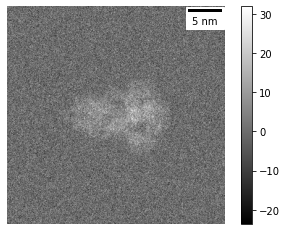

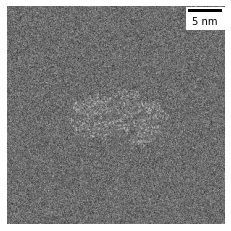

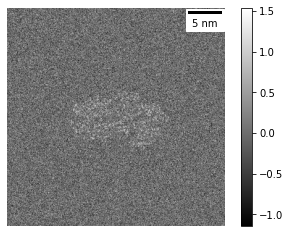

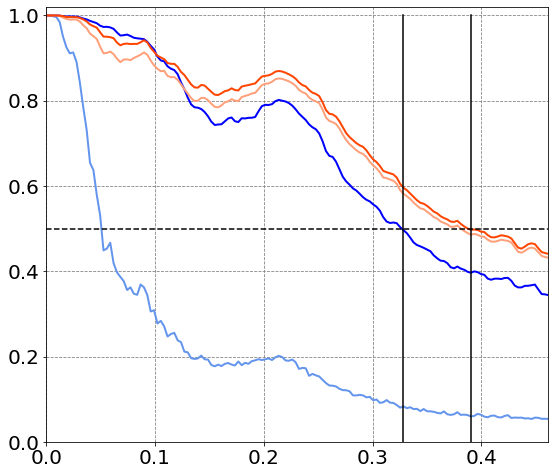

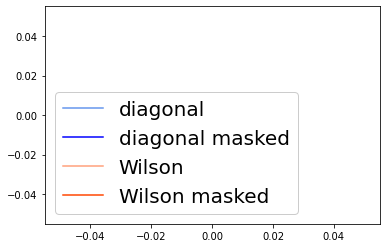

,resolution
diagonal,3.045189
wilson,2.561825


/Users/marcaurele/opt/anaconda3/envs/wilson/lib/python3.6/tempfile.py:800: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/dg/zzj57d7d1gs1k9l8sdfh043m0000gn/T/tmpviyle98b'>
  _warnings.warn(warn_message, ResourceWarning)
/Users/marcaurele/opt/anaconda3/envs/wilson/lib/python3.6/site-packages/dataframe_image/_pandas_accessor.py:76: ResourceWarning: unclosed file <_io.BufferedWriter name='/Users/marcaurele/research/wilsontest/results/denoisingscores_table-2.png'>
  open(filename, 'wb').write(img_str)


In [12]:
# experiment_name should be denoising or deconvolution
experiment_name = "denoising" 
log_SNR = -2
signal_norm_sq = np.linalg.norm(clean_image) **2 / clean_image.size

# Generate the matrix A.
filter_on_grid = gsd.get_experiment_CTF(experiment_name, image_shape, voxel_size)

# Set noise level
noise_variance =  signal_norm_sq / 10**(log_SNR)
noise_variance_ft = noise_variance * np.prod(image_shape) 

# Generate noisy noisy image with real noise in the real domain.
clean_image_ft = get_fourier_transform(clean_image, voxel_size = voxel_size)
noise_ft = get_fourier_transform(np.random.randn(*clean_image.shape)* np.sqrt(noise_variance) , voxel_size = voxel_size)
noisy_images_ft = filter_on_grid * clean_image_ft +  noise_ft
noisy_images = get_inverse_fourier_transform(noisy_images_ft , voxel_size = voxel_size)

denoised_images = {}

## Solve with the diagonal prior
name = "diagonal"
print(name)
start_time = time.time()
prior_mean, prior_cov_fn = priors.get_diagonal_prior_mean_covariance( clean_image, voxel_size)
denoised_image_fourier = priors.weiner_filter(noisy_images_ft, prior_mean.reshape(image_shape), prior_cov_fn, noise_variance_ft, filter_on_grid, diagonal_flag= True).reshape(*image_shape)
denoised_images[name] = np.real(get_inverse_fourier_transform(denoised_image_fourier, voxel_size = voxel_size))
end_time = time.time()
print("Time elapsed:", end_time - start_time)

## Solve with the Wilson prior
name = "wilson"
print(name)
start_time = time.time()
convolution_sigma = 1
prior_mean, prior_cov_fn = priors.get_wilson_prior_mean_covariance( N_atoms, atom_shape_fn, denoised_images["diagonal"], voxel_size, convolution_sigma)  
denoised_image_fourier = priors.weiner_filter(noisy_images_ft, prior_mean.reshape(image_shape), prior_cov_fn, noise_variance_ft, filter_on_grid, diagonal_flag = False).reshape( *image_shape)
denoised_images[name] = np.real(get_inverse_fourier_transform(denoised_image_fourier, voxel_size = voxel_size))
end_time = time.time()
print("Time elapsed:", end_time - start_time)

# Plot all images
make_images_for_paper(denoised_images, clean_image, noisy_images, mask, grid_size, voxel_size, save_directory, experiment_name, log_SNR, save_to_file)
